# COMP4318/5318 Assignment 2: Image Classification

### Group number: ...  , SID1: ... , SID2: ..., SID3: ... 

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [432]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


# Model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# FCNN and CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
import tensorflow as tf

import warnings




## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [433]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

In [434]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


In [435]:
# flatten the labels
y_train_flat = y_train.flatten()
label_counts = pd.Series(y_train_flat).value_counts().sort_index()
print(label_counts)

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: count, dtype: int64


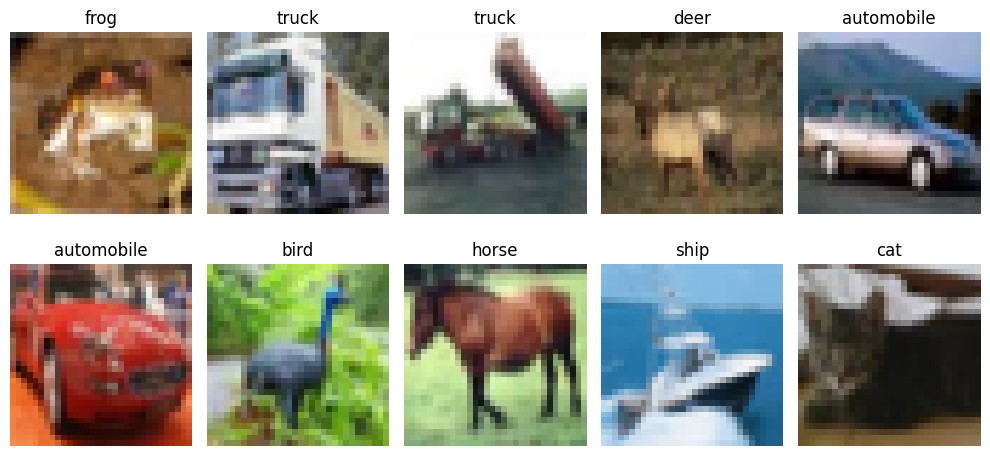

In [436]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    # Handle both (50000, 1) and (50000,) cases
    label_index = y_train[i] if np.ndim(y_train) == 1 else y_train[i][0]
    plt.title(class_names[label_index])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [437]:
from sklearn.model_selection import train_test_split

y_train = y_train.flatten()
y_test = y_test.flatten()

# Normalize pixel values for all models 
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# One-hot encode labels for Neural Networks 
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Flatten images for classical models
X_train_flat = X_train_norm.reshape((X_train.shape[0], -1))
X_test_flat = X_test_norm.reshape((X_test.shape[0], -1))

# 5. Subsample for classical models to prevent overload
X_small, _, y_small, _ = train_test_split(
    X_train_flat, y_train, train_size=2000, stratify=y_train, random_state=42
)
X_test_small, _, y_test_small, _ = train_test_split(
    X_test_flat, y_test, train_size=400, stratify=y_test, random_state=42
)
# Normalize images for neural networks
X_small_norm = X_small.astype("float32") / 255.0
X_test_small_norm = X_test_small.astype("float32") / 255.0

scaler = StandardScaler()
X_small_scaled = scaler.fit_transform(X_small)
X_test_small_scaled = scaler.transform(X_test_small)

X_small_norm = X_train_norm[:2000]
y_small_cat = y_train_cat[:2000]
X_test_small_norm = X_test_norm[:400]
y_test_small_cat = y_test_cat[:400]

print("Reduced classical training shape:", X_small.shape)
print("Reduced classical test shape:", X_test_small.shape)

Reduced classical training shape: (2000, 3072)
Reduced classical test shape: (400, 3072)


In [438]:
X_small_norm.shape

(2000, 32, 32, 3)

In [439]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

KeyboardInterrupt: 

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

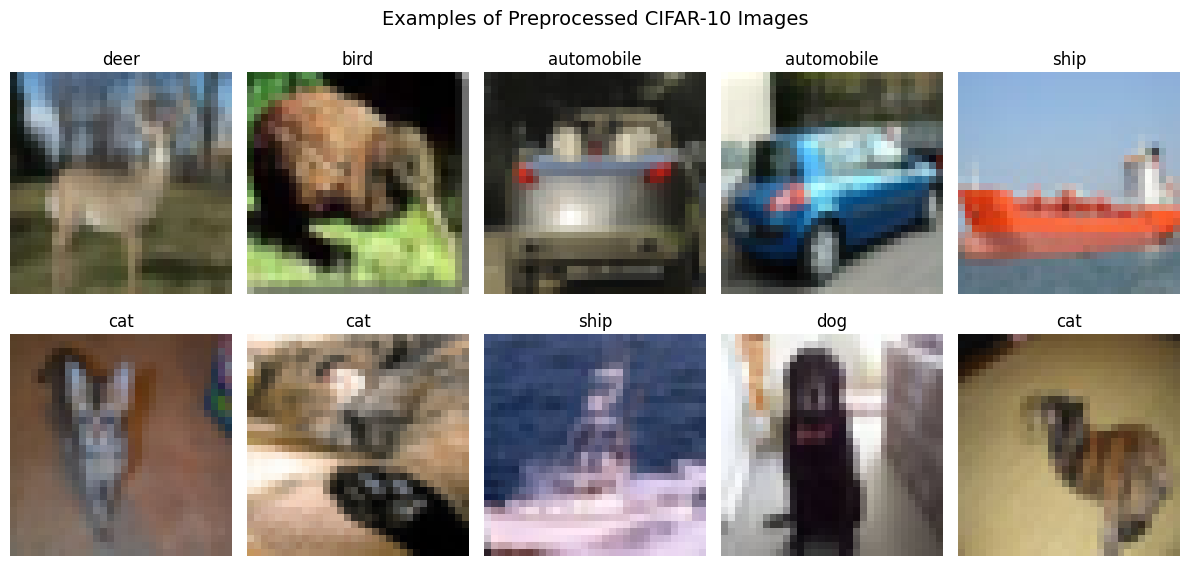

In [ ]:
# Based on https://www.cs.toronto.edu/~kriz/cifar.html
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Randomly choose 10 samples
indices = np.random.choice(len(X_train), 10, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.title(class_names[y_train_flat[idx]])
    plt.axis('off')
plt.suptitle("Examples of Preprocessed CIFAR-10 Images", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.callbacks import EarlyStopping

# def build_mlp(hidden_units=[512, 256], dropout=0.5, lr=0.001):
#     model = Sequential()
#     model.add(Flatten(input_shape=(32,32,3)))
#     for units in hidden_units:
#         model.add(Dense(units, activation='relu'))
#         model.add(Dropout(dropout))
#     model.add(Dense(10, activation='softmax'))

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Try different configurations
# configs = [
#     {'hidden_units':[256,128], 'dropout':0.3},
#     {'hidden_units':[512,256], 'dropout':0.5},
# ]

# for cfg in configs:
#     print(f"Testing config: {cfg}")
#     mlp = build_mlp(hidden_units=cfg['hidden_units'], dropout=cfg['dropout'])
#     mlp.fit(X_train_norm, y_train_cat,
#             epochs=10,
#             batch_size=128,
#             validation_split=0.2,
#             callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
#             verbose=1)
#     val_loss, val_acc = mlp.evaluate(X_test_norm, y_test_cat)
#     print("Test Accuracy:", val_acc)

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# def build_cnn(num_filters=[32,64], dense_units=128, dropout=0.5):
#     model = Sequential()
#     model.add(Conv2D(num_filters[0], (3,3), activation='relu', input_shape=(32,32,3)))
#     model.add(MaxPooling2D((2,2)))
#     model.add(Conv2D(num_filters[1], (3,3), activation='relu'))
#     model.add(MaxPooling2D((2,2)))
#     model.add(Flatten())
#     model.add(Dense(dense_units, activation='relu'))
#     model.add(Dropout(dropout))
#     model.add(Dense(10, activation='softmax'))

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Configurations to try
# cnn_configs = [
#     {'num_filters':[32,64], 'dense_units':128, 'dropout':0.5},
#     {'num_filters':[64,128], 'dense_units':256, 'dropout':0.3},
# ]

# for cfg in cnn_configs:
#     print(f"Testing config: {cfg}")
#     cnn = build_cnn(**cfg)
#     cnn.fit(X_train_norm, y_train_cat,
#             epochs=10,
#             batch_size=128,
#             validation_split=0.2,
#             callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
#             verbose=1)
#     val_loss, val_acc = cnn.evaluate(X_test_norm, y_test_cat)
#     print("Test Accuracy:", val_acc) 

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [441]:
# Classical models
log_reg = LogisticRegression() 
svm = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
adb = AdaBoostClassifier(algorithm='SAMME')
gb = GradientBoostingClassifier()
bag = BaggingClassifier()
nb = GaussianNB()


### Fully connected neural network

In [440]:
from tensorflow.keras.optimizers import Adam

mlp_best_acc = 0
mlp_best_params = {}

for hidden1 in [256, 512]:
    for hidden2 in [128, 256]:
        for dropout_rate in [0.3, 0.5]:
            mlp = Sequential([
                Flatten(input_shape=(32,32,3)),
                # First Hidden Layer
                Dense(hidden1, activation='relu'),
                # Regularize first layer to reduce overfitting
                Dropout(dropout_rate),
                # Learn higher-level, more abstract features
                Dense(hidden2, activation='relu'),
                # Regularize second layer
                Dropout(dropout_rate),
                # Output layer for 10-class classification
                Dense(10, activation='softmax')
            ])
            mlp.compile(optimizer=Adam(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
            
            mlp.fit(X_small_norm, y_small_cat, epochs=10, batch_size=64, verbose=0)
            acc = mlp.evaluate(X_test_small_norm, y_test_small_cat, verbose=0)[1]
            
            if acc > mlp_best_acc:
                mlp_best_acc = acc
                mlp_best_params = {"hidden1": hidden1, "hidden2": hidden2, "dropout": dropout_rate}

print("✅ MLP Best Params:", mlp_best_params)
print("MLP Best Test Accuracy:", mlp_best_acc)

✅ MLP Best Params: {'hidden1': 256, 'hidden2': 256, 'dropout': 0.3}
MLP Best Test Accuracy: 0.3100000023841858


### Convolutional neural network

In [442]:
cnn = Sequential([
    # --- Block 1 ---
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # --- Block 2 ---
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # --- Flatten + Dense Layers ---
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

# --- Compile Model ---
cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

cnn.summary()

Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_114 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_105               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_172 (Dropout)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_106               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_173 (Dropout)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_104 (Flatten)           │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_174 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,482 (2.08 MB)

 Trainable params: 545,290 (2.08 MB)

 Non-trainable params: 192 (768.00 B)

In [443]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2)


In [444]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_small_norm, y_small_cat, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

r = cnn.fit(train_generator, 
              epochs=50,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test_small_norm, y_test_small_cat), 
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )

Epoch 1/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 2s 602us/step - accuracy: 0.2226 - loss: 2.4050 - precision: 0.2680 - recall: 0.0493 - val_accuracy: 0.1775 - val_loss: 2.4355 - val_precision: 0.4516 - val_recall: 0.0350
Epoch 2/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 434us/step - accuracy: 0.2700 - loss: 2.0044 - precision: 0.4660 - recall: 0.0591 - val_accuracy: 0.1575 - val_loss: 4.7804 - val_precision: 0.1562 - val_recall: 0.1425
Epoch 3/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 430us/step - accuracy: 0.2933 - loss: 1.9172 - precision: 0.4761 - recall: 0.0806 - val_accuracy: 0.1250 - val_loss: 7.3702 - val_precision: 0.1269 - val_recall: 0.1250
Epoch 4/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step - accuracy: 0.3397 - loss: 1.8359 - precision: 0.5439 - recall: 0.1199 - val_accuracy: 0.1675 - val_loss: 6.2149 - val_precision: 0.1760 - val_recall: 0.1575
Epoch 5/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 440us/step - accuracy: 0.3518 - loss: 1.7657 - precision: 0.5704 - recall: 0.1382 - val_accuracy: 0

In [455]:
test_loss, test_acc_cnn, test_precision, test_recall = cnn.evaluate(X_test_norm, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc_cnn:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Test Accuracy: 0.5101
Test Precision: 0.5985
Test Recall: 0.4349


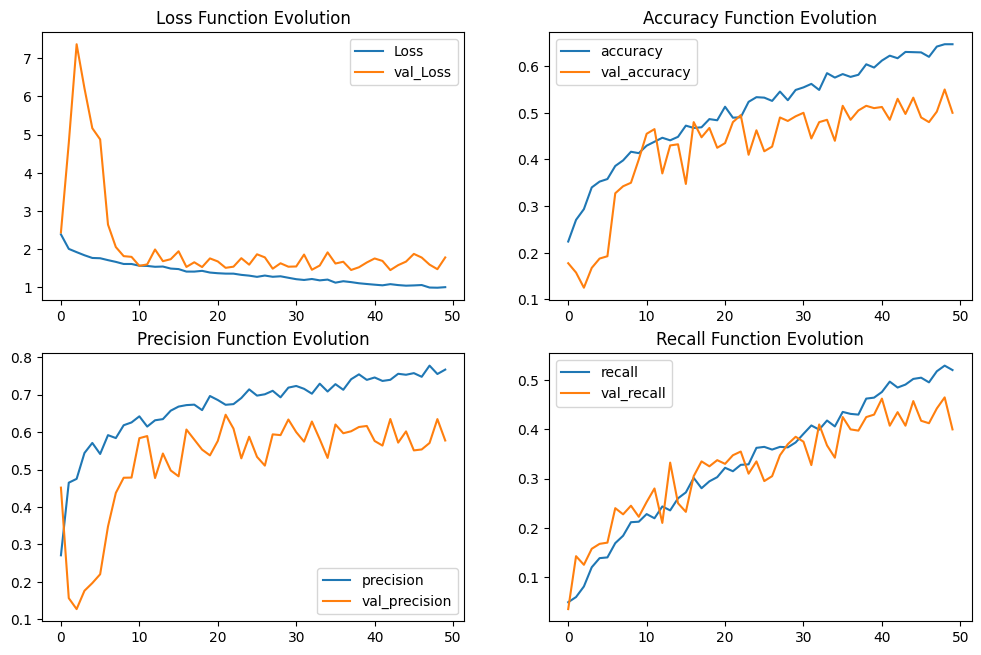

In [446]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


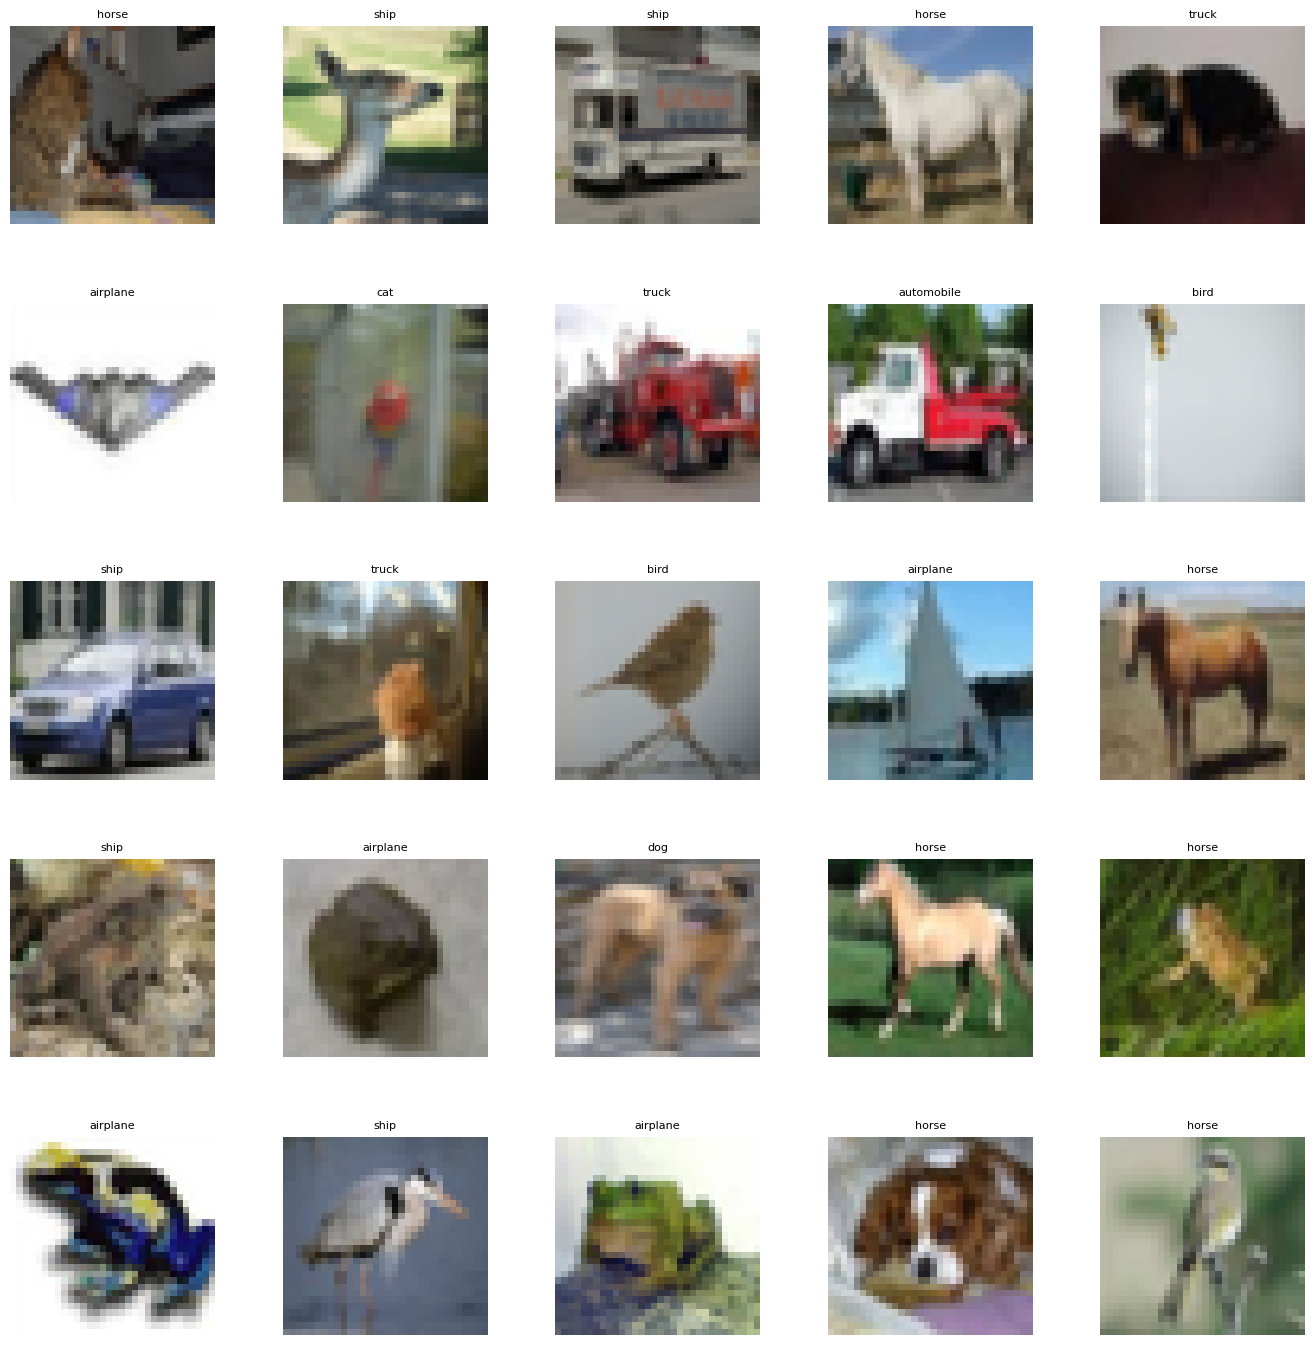

In [447]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']
y_pred = cnn.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index    
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [448]:

# Define base models
models = {
    "Logistic Regression": log_reg,
    "SVM": svm,
    "Decision Tree": dt,
    "Random Forest": rf,
    "AdaBoost": adb,
    "Gradient Boosting": gb,
    "Bagging": bag,
    "Naive Bayes": nb
}

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

In [449]:
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="The max_iter was reached which means the coef_ did not converge")

# Parameter grids
param_grids = {
    "Logistic Regression": {"model__C": [0.1, 1.0], "model__max_iter": [500, 1000]},
    "SVM": {"model__C": [0.1, 1, 10], "model__kernel": ["linear", "rbf"]},
    "Decision Tree": {"model__max_depth": [5, 10, 20, None], "model__min_samples_split": [2, 5, 10]},
    "Random Forest": {"model__n_estimators": [50, 100], "model__max_depth": [10, 20, None]},
    "AdaBoost": {"model__n_estimators": [50, 100], "model__learning_rate": [0.01, 0.1]},
    "Gradient Boosting": {
        "reduce__n_components": [50, 100],   # PCA reduction
        "model__n_estimators": [50, 100],
        "model__learning_rate": [0.01, 0.1],
        "model__max_depth": [1, 3]
    },
    "Bagging": {"model__n_estimators": [50, 100]},
    "Naive Bayes": {}
}

tuned_results = {}
best_models = {}

print("\n✅ Starting model tuning...\n")

# Loop through models
for name, model in models.items():
    print(f"🔹 Tuning {name} ...")

    # --- Step 1: Create pipeline ---
    if name in ["Logistic Regression", "SVM"]:
        pipe = Pipeline([
            ("model", model)
        ])
    elif name == "Gradient Boosting":
        pipe = Pipeline([
            ("reduce", PCA(n_components=0.95)),   # PCA for speed and dimension reduction
            ("model", model)
        ])
    else:
        pipe = Pipeline([
            ("model", model)
        ])

    # --- Step 2: Define GridSearchCV ---
    grid = param_grids[name]
    if len(grid) == 0:
        pipe.fit(X_small, y_small)
        acc = accuracy_score(y_test_small, pipe.predict(X_test_small))
        tuned_results[name] = acc
        best_models[name] = pipe
        print(f"✅ {name}: No tuning. Accuracy = {acc:.4f}")
        continue

    # --- Step 3: Run GridSearchCV ---
    search = GridSearchCV(pipe, grid, cv=10, n_jobs=-1, scoring="accuracy", verbose=0)
    search.fit(X_small, y_small)
    best_pipe = search.best_estimator_

    # --- Step 4: Evaluate ---
    test_acc = accuracy_score(y_test_small, best_pipe.predict(X_test_small))
    tuned_results[name] = test_acc
    best_models[name] = best_pipe

    print(f"✅ {name}: Best Params = {search.best_params_}, Accuracy = {test_acc:.4f}")

print("\n🎯 All models tuned successfully!")


✅ Starting model tuning...

🔹 Tuning Logistic Regression ...


/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

✅ Logistic Regression: Best Params = {'model__C': 0.1, 'model__max_iter': 1000}, Accuracy = 0.3150
🔹 Tuning SVM ...
✅ SVM: Best Params = {'model__C': 10, 'model__kernel': 'rbf'}, Accuracy = 0.3975
🔹 Tuning Decision Tree ...
✅ Decision Tree: Best Params = {'model__max_depth': 10, 'model__min_samples_split': 2}, Accuracy = 0.2525
🔹 Tuning Random Forest ...
✅ Random Forest: Best Params = {'model__max_depth': None, 'model__n_estimators': 100}, Accuracy = 0.4100
🔹 Tuning AdaBoost ...
✅ AdaBoost: Best Params = {'model__learning_rate': 0.1, 'model__n_estimators': 100}, Accuracy = 0.2475
🔹 Tuning Gradient Boosting ...
✅ Gradient Boosting: Best Params = {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'reduce__n_components': 100}, Accuracy = 0.4200
🔹 Tuning Bagging ...
✅ Bagging: Best Params = {'model__n_estimators': 100}, Accuracy = 0.3850
🔹 Tuning Naive Bayes ...
✅ Naive Bayes: No tuning. Accuracy = 0.3150

🎯 All models tuned successfully!


In [456]:
tuned_results['CNN'] = test_acc_cnn
tuned_results['MLP'] = mlp_best_acc
results_df = pd.DataFrame(list(tuned_results.items()), columns=["Model", "Tuned Accuracy"])
print("\n🏁 Hyperparameter Tuning Summary:")
print(results_df)


🏁 Hyperparameter Tuning Summary:
                 Model  Tuned Accuracy
0  Logistic Regression          0.3150
1                  SVM          0.3975
2        Decision Tree          0.2525
3        Random Forest          0.4100
4             AdaBoost          0.2475
5    Gradient Boosting          0.4200
6              Bagging          0.3850
7          Naive Bayes          0.3150
8                  CNN          0.5101
9                  MLP          0.3100


### Fully connected neural network

### Convolutional neural network

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network